## Hypothesis 6: "Rural counties neighboring urban had higher rates than those not near urban areas"

- H0: Rural counties neighboring urban areas have the same COVID-19 case rate as rural counites not near urband areas
- H1: Rural counties neighboring urban areas experienced lower COVID-19 case rate as rural counites not near urband areas
- H2: Rural counties neighboring urban areas experienced higher COVID-19 case rate as rural counites not near urband areas

### Introduction

Intuitively, we expect that a rural county neighboring an urban county experiences more activity than a rural county not adjacent to an urban. Those away from urban centers are more remote and would be expected to have less visitors, business conducted, etc which implies less chance to spread. 

### Approach

- Relationship between the number of urban counties adjacent to rural counties and rate of transmission (Rt)
- Skeptical of simple measures to extract Rt directly from raw data
- Instead, use total cases as the result of Rt
- Stats are per-capita for a fairer comparison between counties
- Counties are split into population groups based on the NCHS 2013 classification 
  - https://www.cdc.gov/nchs/data_access/urban_rural.htm
- For  this analysis, the two smallest classes are used as rural: noncore and micropolitan
- For each rural county, the number of adjacent urban (all other classes) counties are counted
- Visualize the number of adjacent urban counties vs. cases per capita, differentiating noncore and micropolitan

In [25]:
# Load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import re
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches

# Load data
!rm case_clean.csv* test_clean.csv* pop.csv* county_adjacency.txt* TxCoPhrMsa.xls*
# Cumulative cases
!wget --no-check-certificate "https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/case_clean.csv"
# Population density
!wget --no-check-certificate "https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/Population_density.csv" -O pop.csv
# Additional county information (relevant here: rural/metro/etc status)
!wget http://www.dshs.state.tx.us/chs/info/TxCoPhrMsa.xls
# County adjacencies
!wget https://www2.census.gov/geo/docs/reference/county_adjacency.txt
# Texas county boundaries shapefile
!rm counties* County.*
!wget https://opendata.arcgis.com/datasets/9b2eb7d232584572ad53bad41c76b04d_0.zip -O counties.zip
!unzip counties.zip

rm: cannot remove 'test_clean.csv*': No such file or directory
--2020-09-30 18:41:13--  https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/case_clean.csv
Resolving gitlab.tamucc.edu (gitlab.tamucc.edu)... 64.71.82.39
Connecting to gitlab.tamucc.edu (gitlab.tamucc.edu)|64.71.82.39|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 264417 (258K) [text/plain]
Saving to: ‘case_clean.csv’

case_clean.csv      100%[===================>] 258.22K   633KB/s    in 0.4s    

2020-09-30 18:41:14 (633 KB/s) - ‘case_clean.csv’ saved [264417/264417]

--2020-09-30 18:41:14--  https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/Population_density.csv
Resolving gitlab.tamucc.edu (gitlab.tamucc.edu)... 64.71.82.39
Connecting to gitlab.tamucc.edu (gitlab.tamucc.edu)|64.71.82.39|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP r

### Data 

**COVID-19 cumulative cases.**
The hypothesis asks what happens to the rate of transmission.
Here, uses cases as a surrogate for the transmission rate. 
There is an obvious relationship between the two; more cases suggest a higher transmission rate. Note that, while supposedly cumulative, the counts occasionally decrease. The `cummax` function is used to force it to be monotic increasing. 

- Source: DSHS, https://dshs.texas.gov/coronavirus/additionaldata.aspx 


**Texas county populations.** 
The hypothesis asks what affect the rural/urban status has. This data is the population for each county, which is related to that status.

- texascounties.net, http://www.texascounties.net/statistics/popdensity2010.htm

**County adjacencies**
The hypothesis asks about the affect of neighboring counties. This data has the adjacent counties for all US counties. 

Two important notes:
1. "In some instances the boundary between two counties may fall within a body of water,so it seems as if the two counties do not physically touch.  These counties are included on the list as neighbors." - United States Census Bureau
2. "Every county has itself listed as a neighboring county." - United States Census Bureau

- United States Census Bureau, https://www.census.gov/programs-surveys/geography/library/reference/county-adjacency-file.html

**Counties NCHS 2013 classification**
The hypothesis asks about counties based on whether they are urban or rural. The following lists the NCHS 2013 classifications for each county. Here, we tested the hypothesis in two ways, (1) by assuming that both _micropolitan_ and _non-core_ are rural and (2) that only _non-core_ is rural. 

Classifications (metro to rural):
1. large central metro
2. large fringe metro
3. medium metro
4. small metro
5. micropolitan
6. non-core



- Source: DSHS, http://www.dshs.state.tx.us/chs/info/TxCoPhrMsa.xls

In [26]:
# Load data 

# Cumulative cases
dfCase = pd.read_csv("case_clean.csv", index_col = 0)
dfCase_T = dfCase.T
# Cleaning: cumulative must be monotonic increasing
dfCase_T = dfCase_T.cummax()

# County populations
dfPop = pd.read_csv("pop.csv", quotechar = '"', skipinitialspace = True)
dfPop = dfPop.replace(',','', regex=True)
dfPop["Population2010"] = dfPop["Population2010"].apply(pd.to_numeric,errors='coerce')
dfPop = dfPop.drop(dfPop.columns[0], axis = 1)
dfPop = dfPop.drop(dfPop.columns[1], axis = 1)
dfPop = dfPop.drop(dfPop.columns[2], axis = 1)
dfPop["Name"] = dfPop["Name"].str.lower()
dfPop.columns = ["name", "pop"]
dfPop.drop(dfPop.tail(1).index, inplace = True)
# Sort by pop size, smallest to largers
dfPop = dfPop.sort_values(by = "pop")

# Texas population
popTexas = dfPop["pop"].sum()

# Counties
counties = list(dfPop["name"])

# County adjacency
countyAdjFile = "county_adjacency.txt"

# County additional info
countyInfo = pd.read_excel("TxCoPhrMsa.xls", sheet_name = "Sheet1", skiprows = 0)
countyInfo.columns = ["name", "fips", "idx", "phr", "hsr", "msa", "md", "ma82", "nchs2006", "nchs2013", "border32", "border15"] # Simpler columns names
countyInfo = countyInfo.applymap(lambda s:s.lower() if type(s) == str else s) # Lowercase all strings

# Merge county NCHS 2013 metro status
dfPop = pd.merge(dfPop, countyInfo[["name", "nchs2013"]])

# Map NCHS classes to numbers
class2idx = {
    "large central metro" : 5,
    "large fringe metro" : 4,
    "medium metro" : 3, 
    "small metro" : 2,
    "micropolitan" : 1,
    "non-core" : 0,
}

### Map counties to adjacent counties

The original `county_adjacency.txt` is not formatted in a Python-friendly way.
The following code converts it to a dictionary where each county is as key. 
The dictionary item for that key is a list of that county's adjacent counties. 

- Errors when reading as utf-8
- Each county's adjacents are on the following lines, not a simple csv
  - Reasonable since counties have different number of adjacents

Following uses a check to see if the current line is an adjacent county (line starts with tab) or a new county key for the dictionary. Adjacents are appended to the current county's list. 

In [27]:
# Open file into list
with open(countyAdjFile, 'r', encoding = "utf-8", errors = "ignore") as f:
  countyAdjRaw = f.read().split("\n")

# Init empty dictionary
county2adj = {}

# First line is first county
cnty = countyAdjRaw[0].strip('"').split("\t")[0].split(",")[0].replace(" County", "").lower()
# This line also has the first adjacent
adj = countyAdjRaw[0].strip('"').split("\t")[2].split(",")[0].replace(" County", "").lower()

# Add county and its first adjacent to dictionary
county2adj[cnty] = [adj]

# Already
countyAdjRaw.pop(0)
for i, line in enumerate(countyAdjRaw):
  
  # Only want Texas counties
  if "TX" not in line:
    continue

  # If the line starts with a tab, this is another adjacent county to current county's list
  if line[0] == "\t":
    adj = line.strip('"').split("\t")[2].split(",")[0].replace(" County", "").replace('"', "").lower()
    county2adj[cnty].append(adj)

  # Otherwise, set a new current county and it (and its first adjacent) to the dictionary
  else:
    cnty = line.strip('"').split("\t")[0].split(",")[0].replace(" County", "").lower()
    adj = line.strip('"').split("\t")[2].split(",")[0].replace(" County", "").replace('"', "").lower()
    county2adj[cnty] = [adj]

# Now have a dictionary that gives adjacent counties as a list for any query county
print("{c}: {a}".format(c = "nueces", a = county2adj["nueces"]))

nueces: ['aransas', 'jim wells', 'kleberg', 'nueces', 'san patricio']


### Binarize NCHS classifications into _rural_ and _urban_.

In [28]:
# Version 1: rural includes non-core and micropolitan
popClass = np.zeros(len(dfPop.index))
for i, nchs in enumerate(dfPop["nchs2013"]):
  if class2idx[nchs] > 1:
    popClass[i] = 1
  else:
    popClass[i] = 0
dfPop["pop_class_1"] = popClass.astype("int")

# Version 2: rural includes only non-core
popClass = np.zeros(len(dfPop.index))
for i, nchs in enumerate(dfPop["nchs2013"]):
  if class2idx[nchs] > 0:
    popClass[i] = 1
  else:
    popClass[i] = 0
dfPop["pop_class_2"] = popClass.astype("int")


### Map counties by NCHS 2013 classification

The following maps the counties in three ways:

1. All 6 NCHS classifications
2. Binary version 1: rural includes _non-core_ and _micropolitan_
3. Binary version 2: rural includes only _non-core_

In [29]:
# Install Basemap package, if not installed
try:
  m = Basemap()
else:
  !apt-get install libgeos-3.5.0
  !apt-get install libgeos-dev
  !pip install -U git+https://github.com/matplotlib/basemap.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
  Cloning https://github.com/matplotlib/basemap.git to /tmp/pip-req-build-ychemx9x
  Running command git clone -q https://github.com/matplotlib/basemap.git /tmp/pip-req-build-ychemx9x
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756191 sha256=fada4e3733ba2f0277497e474105193e040c1f131120f99f16a3418a8d9c406e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_70sqh55/wheels/3f/f3/56/de548b66967d0d661612b7618022e2c0d4b86b9a638cf6ccf3
Successfully built basemap
  Found existing installation: b

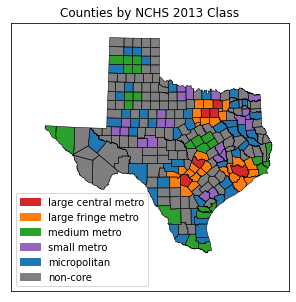

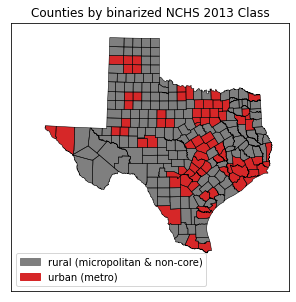

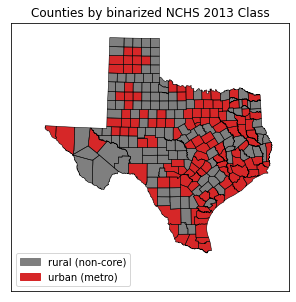

In [30]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

class2idx = {
    "large central metro" : 5,
    "large fringe metro" : 4,
    "medium metro" : 3, 
    "small metro" : 2,
    "micropolitan" : 1,
    "non-core" : 0,
}

# Lat, lon bounds
lllon = -108
urlon = -92
lllat = 23.75
urlat = 37
# Centerpoint
centerlon = float(lllon + urlon) / 2.0
centerlat = float(lllat + urlat) / 2.0

# Plot county map, colored by NCHS 2013 population class
#########################################################
# Init basemap with projection, bounds
m = Basemap(resolution = 'i',
            llcrnrlon = lllon, urcrnrlon = urlon,
            lon_0 = centerlon,
            llcrnrlat = lllat, urcrnrlat = urlat,
            lat_0 = centerlat,
            projection='tmerc')
# Read county boundaries
shp_info = m.readshapefile('County', 'counties', drawbounds = True)
# County colors
colors = [ "tab:gray", "tab:blue",  "tab:purple", "tab:green", "tab:orange", "tab:red" ]
# Format plot
plt.title('Counties by NCHS 2013 Class')
plt.tight_layout(pad = 0, w_pad = 0, h_pad = 0)
ax1 = plt.gca()
# Color each county based on NCHS 2013 population class
for i, county in enumerate(m.counties_info):
  name = county["CNTY_NM"]
  if name == "De Witt":
    name = "dewitt"
  try:
    label = dfPop[dfPop["name"] == name.lower()]["nchs2013"].values[0]
    idx = class2idx[label]
    color = colors[idx]
    countyseg = m.counties[i]
    poly = Polygon(countyseg, facecolor = color)  # edgecolor="white"
    ax1.add_patch(poly)
  except:
    print(name)
# Add custom label
patches = [
            mpatches.Patch(color = colors[5], label = "large central metro", linestyle = "solid"),
            mpatches.Patch(color = colors[4], label = "large fringe metro", linestyle = "solid"),
            mpatches.Patch(color = colors[3], label = "medium metro", linestyle = "solid"),
            mpatches.Patch(color = colors[2], label = "small metro", linestyle = "solid"),
            mpatches.Patch(color = colors[1], label = "micropolitan", linestyle = "solid"),
            mpatches.Patch(color = colors[0], label = "non-core", linestyle = "solid"),
]
ax1.legend(loc = "lower left", handles = patches)
plt.show()


# Plot county map, colored by binary urban/rural population class
#################################################################
# Init basemap with projection, bounds
m = Basemap(resolution = 'i',
            llcrnrlon = lllon, urcrnrlon = urlon,
            lon_0 = centerlon,
            llcrnrlat = lllat, urcrnrlat = urlat,
            lat_0 = centerlat,
            projection='tmerc')
# Read county boundaries
shp_info = m.readshapefile('County', 'counties', drawbounds = True)
# County colors
colors = [ "tab:gray", "tab:red" ]
# Format plot
plt.title('Counties by binarized NCHS 2013 Class')
plt.tight_layout(pad = 0, w_pad = 0, h_pad = 0)
ax = plt.gca()
# Color each county based on binary population class
for i, county in enumerate(m.counties_info):
  name = county["CNTY_NM"]
  if name == "De Witt":
    name = "dewitt"
  try:
    idx = dfPop[dfPop["name"] == name.lower()]["pop_class_1"].values[0]
    color = colors[idx]
    countyseg = m.counties[i]
    poly = Polygon(countyseg, facecolor = color)  # edgecolor="white"
    ax.add_patch(poly)
  except:
    print(name)
# Add custom label
patches = [
            mpatches.Patch(color = colors[0], label = "rural (micropolitan & non-core)", linestyle = "solid"),
            mpatches.Patch(color = colors[1], label = "urban (metro)", linestyle = "solid"),
]
ax.legend(loc = "lower left", handles = patches)
plt.show()


# Plot county map, colored by binary urban/rural population class
#################################################################
# Init basemap with projection, bounds
m = Basemap(resolution = 'i',
            llcrnrlon = lllon, urcrnrlon = urlon,
            lon_0 = centerlon,
            llcrnrlat = lllat, urcrnrlat = urlat,
            lat_0 = centerlat,
            projection='tmerc')
# Read county boundaries
shp_info = m.readshapefile('County', 'counties', drawbounds = True)
# County colors
colors = [ "tab:gray", "tab:red" ]
# Format plot
plt.title('Counties by binarized NCHS 2013 Class')
plt.tight_layout(pad = 0, w_pad = 0, h_pad = 0)
ax = plt.gca()
# Color each county based on binary population class
for i, county in enumerate(m.counties_info):
  name = county["CNTY_NM"]
  if name == "De Witt":
    name = "dewitt"
  try:
    idx = dfPop[dfPop["name"] == name.lower()]["pop_class_2"].values[0]
    color = colors[idx]
    countyseg = m.counties[i]
    poly = Polygon(countyseg, facecolor = color)  # edgecolor="white"
    ax.add_patch(poly)
  except:
    print(name)
# Add custom label
patches = [
            mpatches.Patch(color = colors[0], label = "rural (non-core)", linestyle = "solid"),
            mpatches.Patch(color = colors[1], label = "urban (metro)", linestyle = "solid"),
]
ax.legend(loc = "lower left", handles = patches)
plt.show()

### Adjacency of rural counties to non-rural

For each county, count the number of adjacent urban counties. 

Note that the following includes oneself. So, an urban county like Dallas will include Dallas in its count. Does not affect the analysis since only rural countues are considered; these will not increase the count since they are not urban. 

In [31]:
nMetAdjs = np.zeros(len(counties))
for i, c in enumerate(counties):
  adj = county2adj[c]
  for a in adj:
    try:
      nchs_class = dfPop[dfPop["name"] == a]["nchs2013"].values[0]
      if class2idx[nchs_class] >= 1:
        nMetAdjs[i] += 1
    except:
      # Was likely a county from a border state, fails since not in TX table
      continue
dfPop["num_met_adj"] = nMetAdjs.astype("int")

### Total cases (raw and _per-capita_)

Since transmission rate is not known directly, the simplest measure of spread is total number of cases. 

The following grabs this directly from the cumulative cases. It also uses the population size for _per capita_ total cases.

In [32]:
# Find total cases for each county
dfPop["cases"] = [dfCase_T[c][-1] for c in counties]
dfPop["cases_percap"] = dfPop["cases"] / dfPop["pop"] * 1000

### Visualize relationship between number of adjacent urban counties and total cases



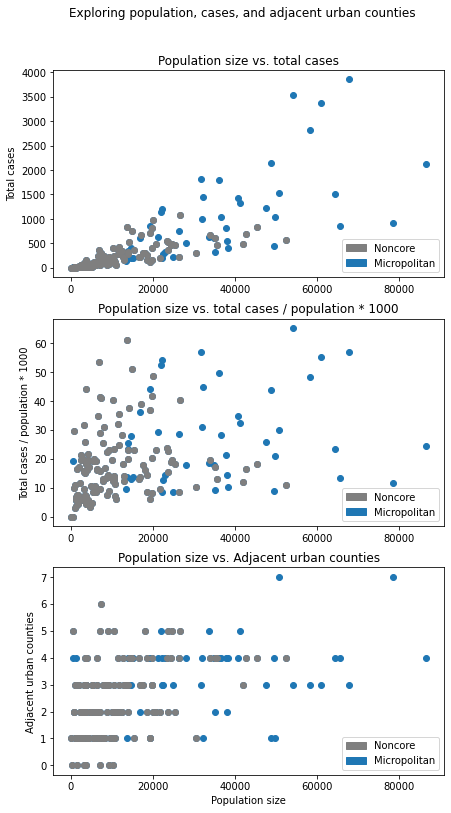

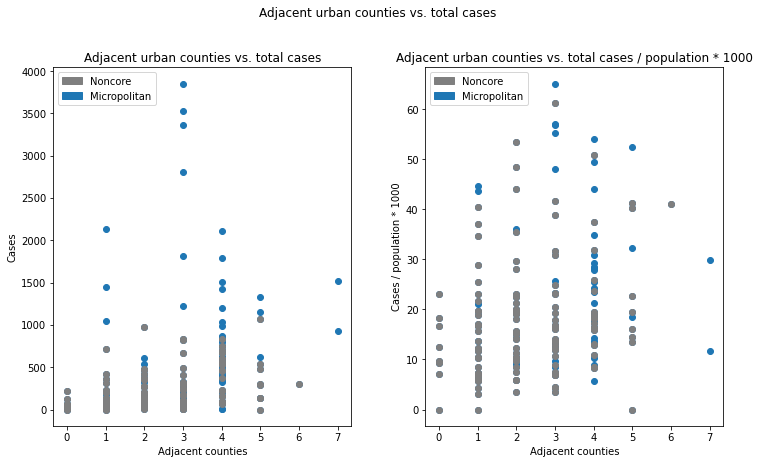

In [35]:
# Version 1: Where rural includes noncore and micropolitan
dfRural = dfPop[dfPop["pop_class_1"] < 1]
# Version 2: Where rural includes only noncore
dfRural2 = dfPop[dfPop["pop_class_2"] < 1]
# Plot colors
colNoncore = "tab:gray"
colMicropol = "tab:blue"

# Labels
patches = [
            mpatches.Patch(color = colNoncore, label = "Noncore", linestyle = "solid"),
            mpatches.Patch(color = colMicropol, label = "Micropolitan", linestyle = "solid"),
]

# Plot cases vs population
fig, axs = plt.subplots(3, figsize = (7, 11))
axs[0].scatter(dfRural["pop"], dfRural["cases"], color = colMicropol)
axs[0].scatter(dfRural2["pop"], dfRural2["cases"], color = colNoncore)
axs[0].set_title("Population size vs. total cases")
axs[0].set_ylabel("Total cases")
axs[0].legend(loc = "lower right", handles = patches)

axs[1].scatter(dfRural["pop"], dfRural["cases_percap"], color = colMicropol)
axs[1].scatter(dfRural2["pop"], dfRural2["cases_percap"], color = colNoncore)
axs[1].set_title("Population size vs. total cases / population * 1000")
axs[1].set_ylabel("Total cases / population * 1000")
axs[1].legend(loc = "lower right", handles = patches)

axs[2].scatter(dfRural["pop"], dfRural["num_met_adj"], color = colMicropol)
axs[2].scatter(dfRural2["pop"], dfRural2["num_met_adj"], color = colNoncore)
axs[2].set_title("Population size vs. Adjacent urban counties")
axs[2].set_xlabel("Population size")
axs[2].set_ylabel("Adjacent urban counties")
axs[2].legend(loc = "lower right", handles = patches)

fig.suptitle("Exploring population, cases, and adjacent urban counties")
plt.subplots_adjust(top = .9, bottom=0.01, hspace=.2, wspace=0.4)
plt.show()

print("\n\n\n")

fig, axs = plt.subplots(1, 2, figsize = (12, 6))
axs[0].scatter(dfRural["num_met_adj"], dfRural["cases"], color = colMicropol)
axs[0].scatter(dfRural2["num_met_adj"], dfRural2["cases"], color = colNoncore)
axs[0].set_title("Adjacent urban counties vs. total cases")
axs[0].set_ylabel("Cases")
axs[0].set_xlabel("Adjacent counties")
axs[0].legend(loc = "upper left", handles = patches)

axs[1].scatter(dfRural["num_met_adj"], dfRural["cases_percap"], color = colMicropol)
axs[1].scatter(dfRural2["num_met_adj"], dfRural2["cases_percap"], color = colNoncore)
axs[1].set_title("Adjacent urban counties vs. total cases / population * 1000")
axs[1].set_ylabel("Cases / population * 1000")
axs[1].set_xlabel("Adjacent counties")
axs[1].legend(loc = "upper left", handles = patches)

fig.suptitle("Adjacent urban counties vs. total cases")
plt.subplots_adjust(top = .84, bottom=0.01, hspace=.2, wspace=0.25)
plt.show()

### Test relationship between number of adjacent urban counties and total cases

Pearson's correlation between number of adj. urban counties and total cases

4 tests:
1. Rural includes _micropolitan_ and _non-core_ + Raw (unscaled) cases 
2. Rural includes _micropolitan_ and _non-core_ + _Per capita_ cases 
3. Rural only _non-core_ + Raw (unscaled) cases 
4. Rural only _non-core_ + _Per capita_ cases 

In [34]:
from scipy.stats.stats import pearsonr

# Version 1: Where rural includes both non-core and micropolitan
dfRural_v1 = dfPop[dfPop["pop_class_1"] < 1]
pearsons_r_v1_raw = pearsonr(dfRural_v1["num_met_adj"], dfRural_v1["cases"])
pearsons_r_v1_percap =pearsonr(dfRural_v1["num_met_adj"], dfRural_v1["cases_percap"])

dfRural_v2 = dfPop[dfPop["pop_class_2"] < 1]
pearsons_r_v2_raw = pearsonr(dfRural_v2["num_met_adj"], dfRural_v2["cases"])
pearsons_r_v2_percap =pearsonr(dfRural_v2["num_met_adj"], dfRural_v2["cases_percap"])

print("Rural includes micropolitan and non-core + Raw (unscaled) cases:")
print("\t\tcoef = {:0.4f},   p-value = {:.10f}\n".format(pearsons_r_v1_raw[0], pearsons_r_v1_raw[1]))

print("Rural includes micropolitan and non-core + Per capita cases:")
print("\t\tcoef = {:0.4f},   p-value = {:.10f}\n".format(pearsons_r_v1_percap[0], pearsons_r_v1_percap[1]))

print("Rural only non-core + Raw (unscaled) cases :")
print("\t\tcoef = {:0.4f},   p-value = {:.10f}\n".format(pearsons_r_v2_raw[0], pearsons_r_v2_raw[1]))

print("Rural only non-core + Per capita cases:")
print("\t\tcoef = {:0.4f},   p-value = {:.10f}\n".format(pearsons_r_v2_percap[0], pearsons_r_v2_percap[1]))

Rural includes micropolitan and non-core + Raw (unscaled) cases:
		coef = 0.2895,   p-value = 0.0001172594

Rural includes micropolitan and non-core + Per capita cases:
		coef = 0.2160,   p-value = 0.0044205808

Rural only non-core + Raw (unscaled) cases :
		coef = 0.4141,   p-value = 0.0000014347

Rural only non-core + Per capita cases:
		coef = 0.2126,   p-value = 0.0168474686



### Results
- Significant p-value, but very low correlation
- There is a discernible shape to the plot, but there is a peak around the middle num. adjacent, instead of linearly increasing.
- Also, wide variance within each num. adj. counties --> cannot effectively guess whether cases will be higher or lower than mean
- Note: low correlation even when using raw (not per capita) numbers